# Taxi Travel Data Analysis

In this demo, we will be doing some demos on temporal feature engineering with the Kaggle Dataset

### Loading libraries, datasets

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch

In [2]:
# # These are all of the files you are given
# df_tr = pd.read_csv("archive/train.csv")
# df_ts = pd.read_csv("archive/test_public.csv")



In [3]:
    # df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
    # df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]

# print(df_tr["TAXI_ID"].value_counts)
# mergd = pd.merge(df_tr, df_ts, on=["TAXI_ID", "ORIGIN_CALL", "ORIGIN_STAND"], suffixes=(None, "_x"))
# # print((mergd))
# mergd = mergd[mergd["POLYLINE"].notnull()].drop(["TRIP_ID_x", "CALL_TYPE_x", "TIMESTAMP_x", "DAY_TYPE_x", "MISSING_DATA_x"], axis=1)

# # print(df_tr["ORIGIN_STAND"].value_counts())
# # print(mergd["ORIGIN_STAND"].value_counts())
# print((mergd))

### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [4]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
# df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [5]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  # print(datetime.now())
  dt = datetime.fromtimestamp(x['TIMESTAMP'])
  # print(dt.timetuple())
    # print(dt.year, dt.month, dt.day, dt.hour, dt.weekday(), dt.minute)
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday(), dt.timetuple().tm_yday

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
# df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
def parse_midnight_minutes(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return (dt.hour * 60 + dt.minute) / 1440

### Create a Prediction File

In [6]:
df_tr = pd.read_csv("archive/train.csv")
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
outlier_threshold = 3
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]
df_trimmed = df_trimmed[df_trimmed['MISSING_DATA'] == False]
df_trimmed = df_trimmed[df_trimmed['LEN'] != 0]
print("Before Trimming: " + str(len(df_tr)))
print("After Trimming: " + str(len(df_trimmed)))
df_tr = df_trimmed
df_tr["ISTEST"] = 0




df_ts = pd.read_csv("archive/test_public.csv")
df_tr[["YR", "MON", "DAY", "HR", "WKDAY", "YRDAY"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_tr = df_tr.drop(["YR", "MON", "DAY", "WKDAY"], axis=1)
df_ts[["YR", "MON", "DAY", "HR", "WKDAY", "YRDAY"]] = df_ts[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_ts = df_ts.drop(["YR", "MON", "DAY", "WKDAY"], axis=1)
df_ts["ISTEST"] = 1

#this filters df_tr such that all values in the columns in on list must match df_ts. 
#if u wanna add more columns (more filtering) add ur column here and take it out of the drop line 3 down from here
df_tr = pd.merge(df_tr, df_ts, how="inner", on=["TAXI_ID"], suffixes=(None, "_x"))
# print((df_tr["YRDAY"].value_counts()))
df_tr = df_tr[df_tr["POLYLINE"].notnull()].drop(["ISTEST_x", "HR_x", "YRDAY_x", "ORIGIN_CALL_x", "ORIGIN_STAND_x", "TRIP_ID_x", "CALL_TYPE_x", "TIMESTAMP_x", "DAY_TYPE_x", "MISSING_DATA_x"], axis=1)
df_ts["POLYLINE"]="trololololo"
trlen = len(df_tr)


df_both = pd.concat([df_tr, df_ts])
df_both["LEN"] = df_both["POLYLINE"].apply(polyline_to_trip_duration)
ocvc = df_both["ORIGIN_CALL"].value_counts()
def filterOC(x):
    if pd.isnull(x):
        return x
    if(ocvc[x] < 100):
        return None
    return x
df_both["ORIGIN_CALL"] = df_both["ORIGIN_CALL"].apply(filterOC)
# print(df_both["ORIGIN_CALL"].value_counts())

df_both["MIDMINS"] = df_both[["TIMESTAMP"]].apply(parse_midnight_minutes, axis=1, result_type="expand")
#df_tr["MIDMINS"]=(df_tr["MIDMINS"]-df_tr["MIDMINS"].min())/(df_tr["MIDMINS"].max()-df_tr["MIDMINS"].min())
df_both = pd.get_dummies(data=df_both, columns=['CALL_TYPE', "ORIGIN_STAND", "ORIGIN_CALL", "YRDAY", "HR", "TAXI_ID"])


df_tr = df_both.iloc[:trlen]
mean, std, median, min, max = df_tr["LEN"].mean(), df_tr["LEN"].std(), df_tr["LEN"].median(), df_tr["LEN"].min(), df_tr["LEN"].max()
print(f"Mean: {mean} STD: {std} Median: {median} Min: {min} Max: {max}")

df_ts = df_both.iloc[trlen:]

# print(df_ts)




Before Trimming: 1710670
After Trimming: 1656255
Mean: 693.1521422025355 STD: 399.09803689601046 Median: 615.0 Min: 15 Max: 2760


In [7]:
df_bin = pd.concat([df_tr.sample(n=round(len(df_tr)/2)), df_ts.sample(n=round(len(df_tr)/2), replace=True)])
print(df_bin)

                    TRIP_ID   TIMESTAMP DAY_TYPE  MISSING_DATA   
849424  1384635089620000129  1384635089        A         False  \
616973  1395243728620000562  1395243728        A         False   
329312  1381326868620000665  1381326868        A         False   
759072  1377121528620000249  1377121528        A         False   
955492  1385090450620000136  1385090450        A         False   
...                     ...         ...      ...           ...   
288                    T296  1414814057        A         False   
142                    T148  1412064430        A         False   
187                    T195  1412617425        A         False   
219                    T227  1412617117        A         False   
16                      T17  1408038804        A         False   

                                                 POLYLINE   LEN  ISTEST   
849424  [[-8.61183,41.146146],[-8.611848,41.146182],[-...   960       0  \
616973  [[-8.601993,41.157162],[-8.602011,41.157135],[...

In [21]:
maxtrain = df_tr["TIMESTAMP"].max()
mintest = df_ts["TIMESTAMP"].min()
print("last training recorded on: ", datetime.fromtimestamp(maxtrain))
print("first testing recorded on: ", datetime.fromtimestamp(mintest))

last training recorded on:  2014-06-30 16:59:14
first testing recorded on:  2014-08-14 09:02:23


In [8]:
# print(df_tr[df_tr["ORIGIN_CALL_2002.0"]]["LEN"].mean())
# print(df_tr["LEN"])

In [9]:

class MyDataset(Dataset):
  def __init__(self, df, bin=False):

    boolcols = list(df.columns)
    badcols = ["TRIP_ID", 'MIDMINS',  'TIMESTAMP', 'MISSING_DATA', 'POLYLINE', 'LEN', "DAY_TYPE", "ISTEST"] 
    for b in badcols:
      boolcols.remove(b)
    print(boolcols)
    
    
         
    boolz=df[boolcols].values
    intz = df["MIDMINS"].values
    # print(boolz)
    y=df["LEN"].values
    if(bin):
      y = df["ISTEST"].values

    booltens = torch.tensor(boolz,dtype=torch.float32)
    inttens = torch.tensor(intz,dtype=torch.float32).unsqueeze(1)

    # print(booltens.shape)
    # print(inttens.shape)
 
    self.x_train=torch.cat([booltens, inttens], dim=1)
    # print(self.x_train)
    self.y_train=torch.tensor(y,dtype=torch.float32)
    self.df = df
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [10]:
from torch.utils.data import random_split
trds=MyDataset(df_tr)
trds, valds = random_split(trds, [0.95, 0.05])
print(len(trds), len(valds))
train_loader=DataLoader(trds,batch_size=64, shuffle=True)
val_loader=DataLoader(valds)
binds = MyDataset(df_bin, bin=True)
bin_loader = DataLoader(binds, batch_size=64, shuffle=True)

['CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C', 'ORIGIN_STAND_1.0', 'ORIGIN_STAND_2.0', 'ORIGIN_STAND_3.0', 'ORIGIN_STAND_4.0', 'ORIGIN_STAND_5.0', 'ORIGIN_STAND_6.0', 'ORIGIN_STAND_7.0', 'ORIGIN_STAND_8.0', 'ORIGIN_STAND_9.0', 'ORIGIN_STAND_10.0', 'ORIGIN_STAND_11.0', 'ORIGIN_STAND_12.0', 'ORIGIN_STAND_13.0', 'ORIGIN_STAND_14.0', 'ORIGIN_STAND_15.0', 'ORIGIN_STAND_16.0', 'ORIGIN_STAND_17.0', 'ORIGIN_STAND_18.0', 'ORIGIN_STAND_19.0', 'ORIGIN_STAND_20.0', 'ORIGIN_STAND_21.0', 'ORIGIN_STAND_22.0', 'ORIGIN_STAND_23.0', 'ORIGIN_STAND_24.0', 'ORIGIN_STAND_25.0', 'ORIGIN_STAND_26.0', 'ORIGIN_STAND_27.0', 'ORIGIN_STAND_28.0', 'ORIGIN_STAND_29.0', 'ORIGIN_STAND_30.0', 'ORIGIN_STAND_31.0', 'ORIGIN_STAND_32.0', 'ORIGIN_STAND_33.0', 'ORIGIN_STAND_34.0', 'ORIGIN_STAND_35.0', 'ORIGIN_STAND_36.0', 'ORIGIN_STAND_37.0', 'ORIGIN_STAND_38.0', 'ORIGIN_STAND_39.0', 'ORIGIN_STAND_40.0', 'ORIGIN_STAND_41.0', 'ORIGIN_STAND_42.0', 'ORIGIN_STAND_43.0', 'ORIGIN_STAND_44.0', 'ORIGIN_STAND_45.0', 'ORIGIN_STAND_46.0

In [22]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=1)
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        self.dro = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(870, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):

        
        x = F.relu(self.fc1(x))
        x = self.dro(x)
        x = F.relu(self.fc2(x))
        x = self.dro(x)
        x = F.relu(self.fc3(x))
        x = self.dro(x)
        x = self.fc4(x)
        # x = torch.transpose(x, 0, 1)
        return x
net = Net()

In [12]:
class BinaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.dro = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(870, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dro(x)
        x = F.relu(self.fc2(x))
        x = self.dro(x)
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x
binarynet = BinaryNet()

In [23]:
import torch.optim as optim
bincriterion = nn.BCELoss()
binoptimizer = optim.Adam(binarynet.parameters(), lr=0.00001)

In [14]:
binarynet.train()
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(bin_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        binoptimizer.zero_grad()

        # forward + backward + optimize
        labels=labels.unsqueeze(1)
        outputs = binarynet(inputs)
        
        loss = bincriterion(outputs, labels)
        loss.backward()
        binoptimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
            #print(outputs[0], labels[0])
        if i%100==99:
            print(f'[{epoch + 1}] loss: {running_loss / len(bin_loader):.3f}')
            print(outputs[0], labels[0])
            running_loss = 0.0

print('Finished Training')


[1] loss: 0.003
tensor([0.5324], grad_fn=<SelectBackward0>) tensor([1.])
[1] loss: 0.003
tensor([0.5269], grad_fn=<SelectBackward0>) tensor([1.])
[1] loss: 0.003
tensor([0.5281], grad_fn=<SelectBackward0>) tensor([1.])
[1] loss: 0.003
tensor([0.5246], grad_fn=<SelectBackward0>) tensor([1.])
[1] loss: 0.003
tensor([0.5187], grad_fn=<SelectBackward0>) tensor([0.])
[1] loss: 0.003
tensor([0.5254], grad_fn=<SelectBackward0>) tensor([0.])
[1] loss: 0.003
tensor([0.5217], grad_fn=<SelectBackward0>) tensor([1.])
[1] loss: 0.003
tensor([0.5246], grad_fn=<SelectBackward0>) tensor([1.])
[1] loss: 0.003
tensor([0.5185], grad_fn=<SelectBackward0>) tensor([1.])
[1] loss: 0.003
tensor([0.5205], grad_fn=<SelectBackward0>) tensor([1.])
[1] loss: 0.003
tensor([0.5249], grad_fn=<SelectBackward0>) tensor([0.])
[1] loss: 0.003
tensor([0.5257], grad_fn=<SelectBackward0>) tensor([1.])
[1] loss: 0.003
tensor([0.5291], grad_fn=<SelectBackward0>) tensor([1.])
[1] loss: 0.003
tensor([0.5305], grad_fn=<SelectBac

In [24]:
import torch.optim as optim
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
def badidea(yhat,y,bvalue):
    return torch.mean(bvalue * torch.abs((yhat-y)))
criterion = RMSELoss
optimizer = optim.Adam(net.parameters(), lr=0.00001)

In [25]:
import time

net.train()
losses = []
times = []
start = time.time()
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        labels=labels.unsqueeze(1)
        outputs = net(inputs)
        
        # binoutputs = binarynet(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
            #print(outputs[0], labels[0])
        if i%1000==999:
            print(f'[{epoch + 1}] loss: {running_loss / 1000:.3f}')
            print(outputs[0], labels[0])
            losses.append(running_loss / 1000)
            times.append(time.time()-start)
            running_loss = 0.0

    # running_loss = 0.0

print('Finished Training')


[1] loss: 797.555
tensor([0.0874], grad_fn=<SelectBackward0>) tensor([1080.])
[1] loss: 799.477
tensor([0.9920], grad_fn=<SelectBackward0>) tensor([195.])
[1] loss: 791.839
tensor([6.1234], grad_fn=<SelectBackward0>) tensor([645.])
[1] loss: 792.045
tensor([10.6732], grad_fn=<SelectBackward0>) tensor([720.])
[1] loss: 777.898
tensor([31.3993], grad_fn=<SelectBackward0>) tensor([420.])
[1] loss: 763.346
tensor([46.9115], grad_fn=<SelectBackward0>) tensor([495.])
[1] loss: 733.646
tensor([97.7334], grad_fn=<SelectBackward0>) tensor([615.])
[1] loss: 704.891
tensor([162.2191], grad_fn=<SelectBackward0>) tensor([645.])
[1] loss: 658.409
tensor([287.0467], grad_fn=<SelectBackward0>) tensor([345.])
[1] loss: 608.945
tensor([301.2354], grad_fn=<SelectBackward0>) tensor([825.])
[1] loss: 546.277
tensor([423.2489], grad_fn=<SelectBackward0>) tensor([825.])
[1] loss: 494.085
tensor([449.7378], grad_fn=<SelectBackward0>) tensor([240.])
[1] loss: 455.664
tensor([419.0476], grad_fn=<SelectBackward0

KeyboardInterrupt: 

In [29]:
print(times[-1], losses[-1])

401.2102930545807 424.5237334594727


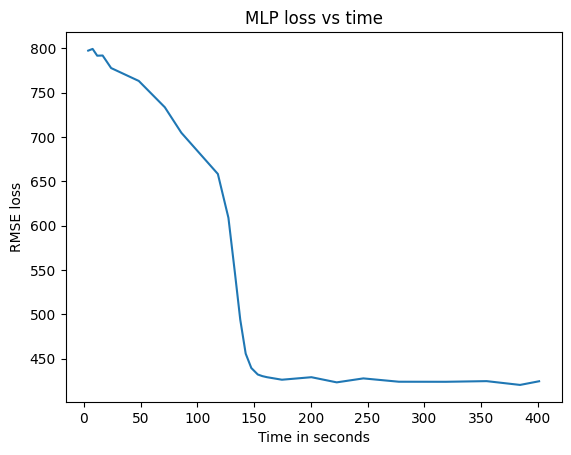

In [27]:
plt.plot(times, losses)
plt.xlabel("Time in seconds")
plt.ylabel("RMSE loss")
plt.title("MLP loss vs time")
plt.show()

In [ ]:
net.eval()

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dro): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=870, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
total_loss = 0.0
with torch.no_grad():
    
    for i, data in enumerate(val_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data


        # forward + backward + optimize
        labels=labels
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)


        # print statistics
        total_loss += loss.item()
        # if i%1000==0:
        #     print(round(loss.item()), outputs, labels)

print(f'Total Loss: {total_loss / len(val_loader):.3f}')


Total Loss: 290.280


In [ ]:
testset = MyDataset(df_ts)
testloader = DataLoader(testset)
preds = []
with torch.no_grad():
    for data in testloader:
        features, labels = data
        # calculate outputs by running images through the network
        output = net(features)
        preds.append(output.item())
ids = testset.df["TRIP_ID"]        
print(preds)
d = {"TRIP_ID" : ids, "TRAVEL_TIME" : preds}
newdf = pd.DataFrame(d)
mean, std, median, min, max = newdf["TRAVEL_TIME"].mean(), newdf["TRAVEL_TIME"].std(), newdf["TRAVEL_TIME"].median(), newdf["TRAVEL_TIME"].min(), newdf["TRAVEL_TIME"].max()
print(f"Mean: {mean} STD: {std} Median: {median} Min: {min} Max: {max}")
print(newdf)
newdf.to_csv("my_pred.csv", index=None)

['CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C', 'ORIGIN_STAND_1.0', 'ORIGIN_STAND_2.0', 'ORIGIN_STAND_3.0', 'ORIGIN_STAND_4.0', 'ORIGIN_STAND_5.0', 'ORIGIN_STAND_6.0', 'ORIGIN_STAND_7.0', 'ORIGIN_STAND_8.0', 'ORIGIN_STAND_9.0', 'ORIGIN_STAND_10.0', 'ORIGIN_STAND_11.0', 'ORIGIN_STAND_12.0', 'ORIGIN_STAND_13.0', 'ORIGIN_STAND_14.0', 'ORIGIN_STAND_15.0', 'ORIGIN_STAND_16.0', 'ORIGIN_STAND_17.0', 'ORIGIN_STAND_18.0', 'ORIGIN_STAND_19.0', 'ORIGIN_STAND_20.0', 'ORIGIN_STAND_21.0', 'ORIGIN_STAND_22.0', 'ORIGIN_STAND_23.0', 'ORIGIN_STAND_24.0', 'ORIGIN_STAND_25.0', 'ORIGIN_STAND_26.0', 'ORIGIN_STAND_27.0', 'ORIGIN_STAND_28.0', 'ORIGIN_STAND_29.0', 'ORIGIN_STAND_30.0', 'ORIGIN_STAND_31.0', 'ORIGIN_STAND_32.0', 'ORIGIN_STAND_33.0', 'ORIGIN_STAND_34.0', 'ORIGIN_STAND_35.0', 'ORIGIN_STAND_36.0', 'ORIGIN_STAND_37.0', 'ORIGIN_STAND_38.0', 'ORIGIN_STAND_39.0', 'ORIGIN_STAND_40.0', 'ORIGIN_STAND_41.0', 'ORIGIN_STAND_42.0', 'ORIGIN_STAND_43.0', 'ORIGIN_STAND_44.0', 'ORIGIN_STAND_45.0', 'ORIGIN_STAND_46.0